# Numerai: Machine Learning Hedge Fond

In [1]:
from __future__ import print_function

In [2]:
import warnings

# Disable warnings emitted by warnings.warn calls from different packages
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn import grid_search
from sklearn import ensemble
from sklearn import cross_validation
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline, FeatureUnion

import keras
import theano
import tensorflow as tf
from tensorflow.contrib import learn

from collections import OrderedDict
import pickle
import time

In [5]:
# t-SNE feature extraction
import tsne

In [6]:
sns.set_context('notebook', font_scale=1.25)
sns.set_style('darkgrid')

In [7]:
%matplotlib inline

## Read data files and prepare train & test samples

In [8]:
# Data sets
TRAINING_SET = 'numerai_datasets/numerai_training_data.csv'
TEST_SET = 'numerai_datasets/numerai_tournament_data.csv'

# Load datasets.
training_set = pd.read_csv(TRAINING_SET)
test_set = pd.read_csv(TEST_SET, index_col=0)

In [9]:
training_set.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,0.581007,0.908596,0.766110,0.844650,0.247000,0.600018,0.827638,0.726782,0.596622,0.383684,...,0.083463,0.537761,0.613012,0.672179,0.422369,0.727817,0.884887,0.267128,0.352174,1
1,0.050758,0.905095,0.966358,0.991736,0.637117,0.956871,0.804695,0.994215,0.967192,0.083801,...,0.054114,0.066266,0.715163,0.796705,0.826976,0.734355,0.805943,0.832481,0.659629,1
2,0.425571,0.691507,0.920220,0.594960,0.591689,0.525516,0.862749,0.549405,0.225714,0.333259,...,0.648824,0.407148,0.383214,0.478281,0.240681,0.937534,0.967276,0.483772,0.671841,0
3,0.458899,0.210681,0.118947,0.362672,0.243417,0.729953,0.010813,0.061358,0.879345,0.740620,...,0.474311,0.387113,0.763792,0.437354,0.876841,0.015405,0.006289,0.522826,0.564926,0
4,0.922149,0.414926,0.530944,0.656192,0.756348,0.678726,0.000730,0.400667,0.200305,0.854789,...,0.948615,0.972195,0.326792,0.643454,0.450616,0.081692,0.048362,0.456337,0.557026,0


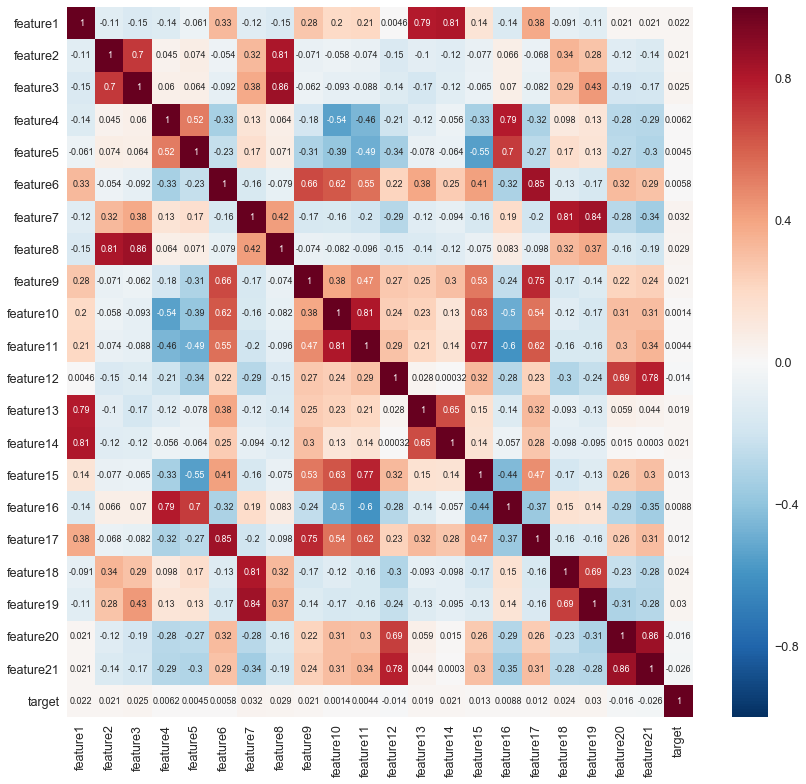

In [10]:
# Predictivity
pearson = training_set.corr('pearson')
pearson.ix[-1][:-1].sort_values()
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(12,11))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=9), vmin=-1, vmax=1, ax=ax)
plt.tight_layout()
plt.show()

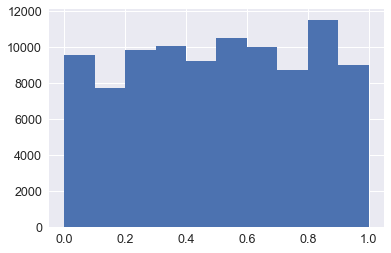

In [12]:
plt.hist(training_set['feature1']);

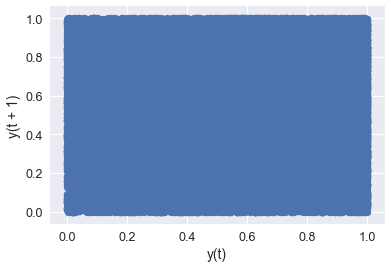

In [14]:
# Autocorrelation
pd.tools.plotting.lag_plot(training_set['feature1']);

(0, 100)

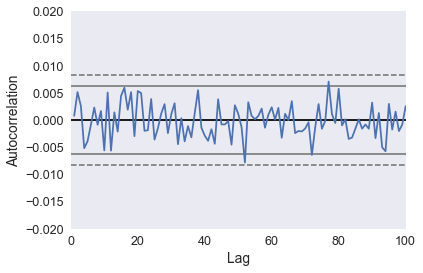

In [15]:
ax = pd.tools.plotting.autocorrelation_plot(training_set['feature1'])
ax.set_ylim(-0.02, 0.02)
ax.set_xlim(0,100)

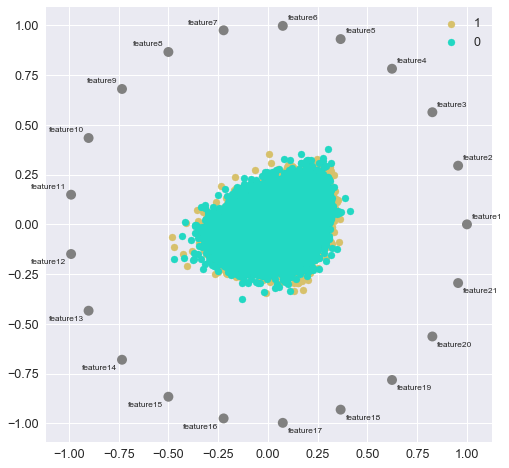

In [16]:
plt.figure(figsize=(8,8))
pd.tools.plotting.radviz(training_set, 'target')

In [ ]:
# Reverse dataset order (by index) to use latest data points
# Training dataset
training_set = training_set.iloc[::-1]
# Prediction dataset (tournament)
test_set = test_set.iloc[::-1];

## Train test dataset split

In [18]:
# Training dataset
X_data = training_set.ix[:,0:21].values
print(X_data.shape)
y_data = training_set['target'].values
print(y_data.shape)

(96320, 21)
(96320,)


In [19]:
# Prediction dataset
X_predict = test_set.values
print(X_predict.shape)

(135281, 21)


#### A) Split data while preserve ordering (time-series data?)

In [ ]:
# Split dataset into training and test sets (preserve ordering)
percent = 0.85
split = int(percent*X_data.shape[0])
X_train = X_data[:split,:]
y_train = y_data[:split]
X_test = X_data[split:,:]
y_test = y_data[split:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#### B) Split data using random ordering 

In [20]:
# Split data into train and test samples (random ordering)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_data, y_data, train_size=0.8)

### Feature engineering

#### A) Enginner new features using PCA & LDA

In [ ]:
# Select best features using principal component analysis
pca = PCA(n_components=4)
lda = LinearDiscriminantAnalysis(n_components=2)
# Make a union of features
union = FeatureUnion([('LDA',lda), ('PCA',pca)])
# Note: This 'union' can be used in Pipeline with any classifier 
#       (see below an example with Logistic regression)

In [ ]:
# Alternative: Instead of using FeatureUnion in Pipeline, it can
# be used to transform the train, test and validate data sets
union_transform = union.fit(X_train, y_train)
X_train_best = union_transform.transform(X_train)
X_test_best = union_transform.transform(X_test)
X_predict_best = union_transform.transform(X_predict)
X_train_best.shape

#### B) Engineer new features using t-SNE

In [ ]:
# t-SNE can be used with different 'no_dims' and 'perplexity' values
# providing different features each time (that can be stacked together)
X_train_tsne = tsne.tsne(X_train, no_dims=2, perplexity=30)  # perplexity=30 is default
X_test_tsne = tsne.tsne(X_test, no_dims=2, perplexity=30)
X_predict_tsne = tsne.tsne(X_predict, no_dims=2, perplexity=30)

In [ ]:
# Stack original features with t-SNE features
X_train = np.c_[X_train, X_train_tsne]
X_test = np.c_[X_test, X_test_tsne]
X_predict = np.c_[X_predict, X_predict_tsne]
X_train.shape

#### C) Feature interactions

In [ ]:
# Feature interactions on ***principal component features***
interactions = preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interactions.fit(X_train_best, y_train)
X_train_interact = interactions.transform(X_train_best)
X_test_interact = interactions.transform(X_test_best)
X_predict_interact = interactions.transform(X_predict_best)

In [ ]:
# Stack engineered features with the original ones
X_train = np.c_[X_train, X_train_interact]
X_test = np.c_[X_test, X_test_interact]
X_train.shape

In [ ]:
# Feature interactions using several ***best original features***
k_best = feature_selection.SelectKBest(feature_selection.chi2, k=4)  # 4 'best' features
k_best.fit(X_train, y_train)
X_best_train = k_best.transform(X_train)
X_best_test = k_best.transform(X_test)
X_best_pred = k_best.transform(X_predict)
# build polynomial features (only interactions)
interactions = preprocessing.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interactions.fit(X_best_train, y_train)
X_best_train_inter = interactions.transform(X_best_train)[:,4:]
X_best_test_inter = interactions.transform(X_best_test)[:,4:]
X_best_pred_inter = interactions.transform(X_best_pred)[:,4:]
X_best_train_inter.shape

In [ ]:
# NOTE: Some of the individual classifiers (in the first stage) can be trained 
# on data with extra features and some can be train on the original data set.
# In order to do this, original data sets should NOT be overwritten with new
# features and feature interactions. Instead, new names should be used for the
# 'extended' train (validation and test) datasets which include extra features.

#### D) Stack features

In [ ]:
# Stack engineered features with the original ones
X_train = np.c_[X_train, X_best_train_inter]
X_test = np.c_[X_test, X_best_test_inter]
X_predict = np.c_[X_predict, X_best_pred_inter]

In [ ]:
# Stack original features with principal component features and feature interactions
X_train = np.c_[X_train, X_train_best, X_best_train_inter]
X_test = np.c_[X_test, X_test_best, X_best_test_inter]
X_predict = np.c_[X_predict, X_predict_best, X_best_pred_inter]
X_train.shape

## Train individual classifiers

### Keras Neural Network for Classification

In [ ]:
# NOTE: Needed only with the theano backend!
theano.config.compute_test_value = 'ignore'

#### A) Feed-forward network

In [ ]:
# Feed-forward neural network for classification
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.Dense(1024, input_dim=X_train.shape[1]))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dropout(0.5))
# hidden layer
model.add(keras.layers.Dense(512, init='glorot_uniform'))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dropout(0.5))
# hidden layer
model.add(keras.layers.Dense(256, init='glorot_uniform'))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dropout(0.25))
# hidden layer (delete)
model.add(keras.layers.Dense(128, init='glorot_uniform'))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dropout(0.25))
# Output layer
model.add(keras.layers.Dense(2, init='glorot_uniform'))
model.add(keras.layers.Activation('softmax'))

# Optimizer
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-2, nesterov=True)

# Compile network
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#### B) Recurrent neural network

In [ ]:
# Recurrent neural network for classification
model = keras.models.Sequential()

# Input layer
layer = 'lstm'
if layer == 'rnn':
    # Recurrent layer
    model.add(keras.layers.recurrent.SimpleRNN(1024, input_dim=X_train.shape[1], activation='tanh'))
elif layer == 'lstm':
    # Long-Short Term Memory layer
    model.add(keras.layers.recurrent.LSTM(1024, input_dim=X_train.shape[1], activation='tanh'))

hidden = False
if hidden:
    # add another dense hidden layer
    model.add(keras.layers.Dense(512, activation='tanh'))
    model.add(keras.layers.Dropout(0.5))

# Output layer
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('softmax'))

# Optimizer
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-2, nesterov=True)

# Compile network
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Reshape datasets for the recurrent network (see Keras documentation)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#### Train the network and evaluate the score on test data (same code for both networks)

In [ ]:
BATCH = 512  # 'batch_size' argument

In [ ]:
# Encode 'targets' to categorical variables (2 categories: 0, 1)
y_train_nn = keras.utils.np_utils.to_categorical(y_train)
y_test_nn = keras.utils.np_utils.to_categorical(y_test)

In [ ]:
class LossHistory(keras.callbacks.Callback):
    # For recording the training history (loss)
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
# Early stopping of training process (if no improvement)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Record training history
history = LossHistory()

# Start time
start_time = time.time()

# Fit model on train data
model.fit(X_train, y_train_nn, nb_epoch=200, batch_size=BATCH, callbacks=[early_stop, history],
          validation_data=(X_test, y_test_nn), shuffle=False, verbose=0)

# End time
end_time = time.time()
print('Execution time: {:g} seconds'.format(end_time - start_time))

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.losses[100::10])  # every 10th point from 100 to the end
plt.show()

In [ ]:
# Score metrics (evaluate model on test data)
score = model.evaluate(X_test, y_test_nn, batch_size=BATCH, verbose=1)
print('\nLog-loss: {:g}, Accuracy: {:.2f} %'.format(score[0], score[1]*100))

In [ ]:
# Predict class probability on test data
y_pred_proba_nn = model.predict_proba(X_test, batch_size=BATCH)

### Logistic Regression

In [ ]:
# Logistic regression
logreg = LogisticRegression()
# Grid search for optimal parameters
params = {'C':[0.01, 0.1, 1.], 'penalty':['l1', 'l2']}
grid = grid_search.GridSearchCV(estimator=logreg, param_grid=params, cv=3,
                                scoring='log_loss', n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(best_params)

In [23]:
# Predict probability on test data
y_pred_proba_logreg = grid.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_logreg)
print('Log-loss: {:.6f}'.format(logloss))

Log-loss: 0.691383


In [ ]:
# Calibrated Logistic regression classifier
grid_cal = CalibratedClassifierCV(grid, cv=2, method='isotonic')
# Fit
grid_cal.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_logreg = grid_cal.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_logreg)
print('Log-loss: {:.6f}'.format(logloss))

#### Logistic regression with selected features

In [ ]:
# Logistic regression with selected features (using pipeline)
pipeline = Pipeline([('features',union), ('logreg',logreg)])
# Grid search with CV over pipeline 
params = {'logreg__C':[1., 10., 100.], 'logreg__penalty':['l1', 'l2']}
grid_pipe = grid_search.GridSearchCV(pipeline, param_grid=params, cv=2, 
                                     scoring='log_loss', n_jobs=-1)
grid_pipe.fit(X_train, y_train)
best_params = grid_pipe.best_params_
print(best_params)

In [ ]:
# Predict probability on test data
y_pred_proba_logreg = grid_pipe.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_logreg)
print('Log-loss: {:.6f}'.format(logloss))

### Support Vector Machine

In [ ]:
# Support Vector Classification
svc = svm.NuSVC(nu=0.5, kernel='linear', probability=False)  # Slow with: probability=True
# Fit
svc.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_svc = svc.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_svc)
print('Log-loss: {:.6f}'.format(logloss))

### Gaussian Naive Bayes

In [ ]:
# Gaussian Naive Bayes
bayes = GaussianNB()
# Fit
bayes.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_bayes = bayes.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_bayes)
print('Log-loss: {:.6f}'.format(logloss))

In [ ]:
# Naive Bayes with Calibration
calibrate = CalibratedClassifierCV(bayes, cv=5, method='isotonic')
# Fit
calibrate.fit(X_train, y_train)
# Predict probability on test data
y_pred_proba_bayes = calibrate.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_bayes)
print('Log-loss: {:.6f}'.format(logloss))

#### Naive Bayes with Selected Features

In [ ]:
# Naive Bayes with Selected Features (using pipeline)
bayes = GaussianNB()
pipe = Pipeline([('features',union), ('bayes',bayes)])
pipe.fit(X_train, y_train)
# Predict probability on test data
y_pred_proba_bayes = pipe.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_bayes)
print('Log-loss: {:.6f}'.format(logloss))

### Random Forest Classifier

In [ ]:
# Random Forest Classifier
forest = ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                         max_depth=5, oob_score=True, n_jobs=-1)
# Fit
forest.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_forest = forest.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_forest)
print('Log-loss: {:.6f}'.format(logloss))

### Extra Trees Classifier

In [ ]:
# Extra Trees Classifier
trees = ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', max_depth=5, n_jobs=-1)
# Fit
trees.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_trees = trees.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_trees)
print('Log-loss: {:.6f}'.format(logloss))

#### Extra Trees Classifier with Grid search and Cross-validation

In [ ]:
# Extra Trees Classifier with Grid search and Cross-validation
trees = ensemble.ExtraTreesClassifier()
# Grid search for optimal parameters
params = {'n_estimators':[50, 100], 'criterion':['gini', 'entropy'], 'max_depth':[5, 10]}
stacker = grid_search.GridSearchCV(estimator=trees, param_grid=params, cv=2,
                                   scoring='log_loss', n_jobs=-1)
stacker.fit(X_train, y_train)
best_params = stacker.best_params_
print(best_params)

In [ ]:
# Predict probability on test data
y_pred_proba_trees = stacker.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_trees)
print('Log-loss: {:.6f}'.format(logloss))

#### Feature importance

In [ ]:
# Feature importance
feature_importance = trees.feature_importances_
print('Feature importance:')
for feature, name in zip(feature_importance, training_set.columns):
    print('{:8s} => {:g}'.format(name, feature))

In [ ]:
# Select the most important features
features_model = feature_selection.SelectFromModel(trees, prefit=True)
X_train_top = features_model.transform(X_train)
X_train_top.shape

### Gradient Boost Classifier

In [ ]:
# Gradient Boost Classifier
boost_ = ensemble.GradientBoostingClassifier()
# Grid search for optimal parameters
params = {'max_depth':[5, 10], 'learning_rate':[0.001, 0.01], 'n_estimators':[100, 500]}
boost = grid_search.GridSearchCV(estimator=boost_, param_grid=params, cv=2,
                                 scoring='log_loss', n_jobs=-1)
# Fit using train data
boost.fit(X_train, y_train)
best_params = boost.best_params_
print(best_params)

In [25]:
# Predict probability on test data
y_pred_proba_boost = boost.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_boost)
print('Log-loss: {:.6f}'.format(logloss))

Log-loss: 0.691621


#### Feature importance

In [26]:
# Feature importance
boost_features = ensemble.GradientBoostingClassifier(**best_params)
boost_features.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [27]:
feature_importance = boost_features.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx

array([ 4,  1,  3, 17,  9, 19, 16, 15, 14,  5, 10, 11, 12, 13,  0,  2,  6,
       18, 20,  8,  7])

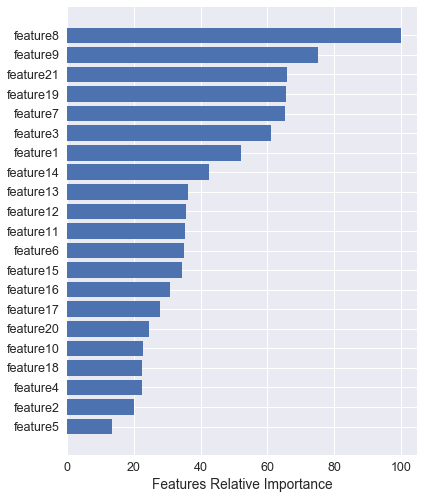

In [28]:
# Visualize relative feature importance
pos = np.arange(sorted_idx.shape[0]) + 1.
fig, ax = plt.subplots(figsize=(6,7))
ax.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, training_set.columns[sorted_idx])
ax.set_xlabel('Features Relative Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Take 3 best features with their interactions
best_3 = [0, 8, 20, (0,8), (0,20), (8,20)]  # feature1, feature9, feature21
# One-way and two-way partial dependence plots
fig, ax = plt.subplots(figsize=(8,7))
ensemble.partial_dependence.plot_partial_dependence(boost_features, X_train, best_3, ax=ax);

### AdaBoost Classifier

In [ ]:
# AdaBoost Classifier
# base estimator is a decision tree if not stated otherhwise
ada_ = ensemble.AdaBoostClassifier(base_estimator=ensemble.ExtraTreesClassifier(n_estimators=50, 
                                   criterion='entropy', max_depth=5))
# Grid search for optimal parameters
params = {'learning_rate':[0.001, 0.01, 0.1], 'n_estimators':[50, 100]}
ada = grid_search.GridSearchCV(estimator=ada_, param_grid=params, cv=2,
                               scoring='log_loss', n_jobs=-1)
# Fit using train data
ada.fit(X_train, y_train)
best_params = ada.best_params_
print(best_params)

In [ ]:
# Predict probability on test data
y_pred_proba_ada = ada.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_ada)
print('Log-loss: {:.6f}'.format(logloss))

### Bagging classifier

In [ ]:
# Bagging classifier 
# base estimator is a decision tree if not stated otherhwise
bagg = ensemble.BaggingClassifier(base_estimator=ensemble.ExtraTreesClassifier(n_estimators=50, 
                                  criterion='entropy', max_depth=5), n_estimators=100, 
                                  max_samples=0.6, max_features=0.8, oob_score=True, n_jobs=-1)
# Fit
bagg.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_bagg = bagg.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_bagg)
print('Log-loss: {:.6f}'.format(logloss))

### Stochastic Gradient Descent

In [ ]:
# Stochastic Gradient Descent Classifier
desc = linear_model.SGDClassifier(loss='log', penalty='l1', learning_rate='constant', 
                                  eta0=0.001, n_jobs=-1)
# Fit
desc.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_desc = desc.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_desc)
print('Log-loss: {:.6f}'.format(logloss))

In [ ]:
# Calibrated Stochastic Gradient Descent Classifier
desc_cal = CalibratedClassifierCV(desc, cv=5, method='isotonic')
# Fit
desc_cal.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_desc = desc_cal.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_desc)
print('Log-loss: {:.6f}'.format(logloss))

### K-Nearest Neighbors

In [ ]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=600, weights='distance', metric='chebyshev', n_jobs=-1)
# Fit
knn.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_knn = knn.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_knn)
print('Log-loss: {:.6f}'.format(logloss))

In [ ]:
# Calibrated KNN Classifier
knn_cal = CalibratedClassifierCV(knn, cv=2, method='isotonic')
# Fit
knn_cal.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_knn = knn_cal.predict_proba(X_test)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_test, y_pred_proba_knn)
print('Log-loss: {:.6f}'.format(logloss))

## Ensamble different classifiers

### A) Ensemble by voting (soft)

In [ ]:
# Ensamble classifiers
use_estimators = [('logreg',logreg), ('bayes',bayes), ('bagg',bagg),
                  ('forest',forest), ('trees',trees), ('ada',ada), 
                  ('boost',boost), ('knn',knn_cal), ('desc',desc_cal)]

# Assign weights for the ensamble
w = [2, 2, 1, 2, 1, 2, 2, 1, 2]

In [ ]:
# Ensamble classifiers (soft voting)
voting = ensemble.VotingClassifier(estimators=use_estimators, voting='soft', weights=w)

In [ ]:
# Fit model using train data
voting.fit(X_train, y_train)

In [ ]:
# Predict probability on test data
y_pred_proba_vote = voting.predict_proba(X_test)

In [ ]:
# Classification accuracy metrics
logloss = metrics.log_loss(y_test, y_pred_proba_vote)
print('Log-loss: {:.6f}'.format(logloss))

### B) Blending different classifiers

In [ ]:
# Different classifiers predictions
ordered_predictions = OrderedDict()
ordered_predictions['keras'] = y_pred_proba_nn[:,1]
ordered_predictions['logreg'] = y_pred_proba_logreg[:,1]
ordered_predictions['bayes'] = y_pred_proba_bayes[:,1]
ordered_predictions['forest'] = y_pred_proba_forest[:,1]
ordered_predictions['trees'] = y_pred_proba_trees[:,1]
ordered_predictions['bagg'] = y_pred_proba_bagg[:,1]
ordered_predictions['boost'] = y_pred_proba_boost[:,1]
ordered_predictions['ada'] = y_pred_proba_ada[:,1]
ordered_predictions['desc'] = y_pred_proba_desc[:,1]
ordered_predictions['knn'] = y_pred_proba_knn[:,1]
proba_all = pd.DataFrame(data=ordered_predictions)

In [ ]:
proba_all.head()

In [ ]:
# Pickle classifier prediction probabilities
with open('classifier_pred_proba.pkl', 'wb') as fout:
    pickle.dump(proba_all, fout)

In [ ]:
proba_all.shape

In [ ]:
y_test.shape

In [ ]:
pearson = proba_all.corr('pearson')
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=9), vmin=-1, vmax=1, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
# Load pickled classifier prediction probabilities
with open('classifier_pred_proba.pkl', 'rb') as fin:
    proba_all = pickle.load(fin)

In [ ]:
# Split the first stage predictions in train & test set
split_ratio = 0.9  # train vs test ratio
N = int(X_test.shape[0]*split_ratio)

In [ ]:
X_train_second = proba_all.values[:N,:]
print(X_train_second.shape)
y_train_second = y_test[:N]
print(y_train_second.shape)
X_validate = proba_all.values[N:,:]
print(X_validate.shape)
y_validate = y_test[N:]
print(y_validate.shape)

In [ ]:
# Split data into train and test samples (random ordering)
X_train_second, X_validate, y_train_second, y_validate = \
    cross_validation.train_test_split(proba_all.values, y_test, train_size=split_ratio)

#### Blending with Logistic Regression

In [ ]:
# Second stage classifier
second = LogisticRegression()
# Grid search for optimal parameters
params = {'C':[0.1, 1., 10.], 'penalty':['l1', 'l2']}
grid_second = grid_search.GridSearchCV(estimator=second, param_grid=params, 
                                       cv=3, scoring='log_loss', n_jobs=-1)
grid_second.fit(X_train_second, y_train_second)
best_params = grid_second.best_params_
print(best_params)
# Predict probability on test data
y_pred_proba_logreg_second = grid_second.predict_proba(X_validate)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_validate, y_pred_proba_logreg_second)
print('Log-loss: {:.6f}'.format(logloss))

#### Blending with Linear Regression

In [ ]:
# Ridge regression with built-in cross validation
linear = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=False, 
                              cv=3, scoring='log_loss')
# Fit
linear.fit(X_train_second, y_train_second)
# Predict
y_pred_linear = linear.predict(X_validate)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_validate, y_pred_linear)
print('Log-loss: {:.6f}'.format(logloss))

#### Blending with Extremely Randomized Trees

In [ ]:
trees_second = ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', max_depth=5, n_jobs=-1)
# Fit
trees_second.fit(X_train_second, y_train_second)
# Predict
trees_second.predict_proba(X_validate)
# Accuracy metrics (log-loss)
logloss = metrics.log_loss(y_validate, y_pred_proba_logreg_second)
print('Log-loss: {:.6f}'.format(logloss))

#### Blending with Keras Network Classifier

In [ ]:
#Build a feed forward neural network for classification
model_blend = keras.models.Sequential()

# Input layer
model_blend.add(keras.layers.Dense(1024, input_dim=proba_all.shape[1], init='glorot_uniform'))
model_blend.add(keras.layers.Activation('tanh'))
model_blend.add(keras.layers.Dropout(0.5))
# hidden layer
model_blend.add(keras.layers.Dense(512, init='glorot_uniform'))
model_blend.add(keras.layers.Activation('tanh'))
model_blend.add(keras.layers.Dropout(0.5))
# Output layer
model_blend.add(keras.layers.Dense(2, init='glorot_uniform'))
model_blend.add(keras.layers.Activation('softmax'))

# Optimizer
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-2, nesterov=True)

# Compile network
model_blend.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Encode 'targets' to categorical variables (2 categories: 0, 1)
y_train_second_nn = keras.utils.np_utils.to_categorical(y_train_second)
y_test_second_nn = keras.utils.np_utils.to_categorical(y_validate)

In [ ]:
# Early stopping of training process (if no improvement)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = LossHistory()
# Fit model on train data
model_blend.fit(X_train_second, y_train_second_nn, nb_epoch=100, 
                batch_size=BATCH, callbacks=[early_stop, history],
                validation_data=(X_validate, y_test_second_nn), 
                shuffle=False, verbose=0)

In [ ]:
# Score metrics (evaluate model on test data)
score = model_blend.evaluate(X_validate, y_test_second_nn, batch_size=BATCH, verbose=1)
print('\nLog-loss: {:g}, Accuracy: {:.2f} %'.format(score[0], score[1]*100))

### C) Stacking different classifiers

In [ ]:
# Stacking best original features (11) and first stage predictions (10)
# Select best original features
k_best = feature_selection.SelectKBest(feature_selection.f_classif, k=5)
pca = PCA(n_components=6)
# Make a union of features (FeatureUnion)
union = FeatureUnion([('KBest',k_best), ('PCA',pca)])
union.fit(X_test, y_test)
# Transform test data set (best features)
X_test_best = union.transform(X_test)

# Stack best features with first stage predictions (11+10=21)
# Train dataset
X_train_union = np.c_[X_test_best[:N,:], X_train_second]
print(X_train_union.shape)
y_train_union = y_test[:N]
print(y_train_union.shape)
# Validate dataset
X_test_union = np.c_[X_test_best[N:,:], X_validate]
print(X_test_union.shape)
y_test_union = y_test[N:]
print(y_test_union.shape)

#### Stacking with TensorFlow DNN Classifier

In [ ]:
# TensorFlow Deep Neural Network Classifier (second stage classifier)
features = learn.infer_real_valued_columns_from_input(X_train_union)

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build a multi-layerr DNN for classification
model_dnn = learn.DNNClassifier(feature_columns=features, hidden_units=[1024, 512],
                                n_classes=2, #model_dir="/tmp/numerai",
                                optimizer=adam, activation_fn=tf.nn.relu, 
                                config=learn.estimators.RunConfig(num_cores=8))

In [ ]:
# Fit model
model_dnn.fit(X_train_union, y_train_union, steps=1000, batch_size=1024)

In [ ]:
# Evaluate on test data
y_pred_proba_dnn = model_dnn.predict_proba(X_test_union)
# Log-loss score
log_loss_score = metrics.log_loss(y_test_union, y_pred_proba_dnn)
print('Log-loss: {0:f}'.format(log_loss_score))

#### Stacking with Extremely Randomized Trees

In [ ]:
mdl = ensemble.ExtraTreesClassifier()
# Grid search for optimal parameters
params = {'n_estimators':[100, 400], 'criterion':['gini', 'entropy'], 'max_depth':[3, 5]}
stacker = grid_search.GridSearchCV(estimator=mdl, param_grid=params, cv=2,
                                   scoring='log_loss', n_jobs=-1)
stacker.fit(X_train_union, y_train_union)
best_params = stacker.best_params_
print(best_params)
# Evaluate on test data
y_pred_proba_stacker = stacker.predict_proba(X_test_union)
# Log-loss score
log_loss_score = metrics.log_loss(y_test_union, y_pred_proba_stacker)
print('Log-loss: {0:f}'.format(log_loss_score))

#### Stacking with Keras Network using Merged branches

In [ ]:
# Left branch (original features)
model1 = keras.models.Sequential()
# Input layer (features)
model1.add(keras.layers.Dense(1024, input_dim=X_train.shape[1], init='glorot_uniform'))
model1.add(keras.layers.Activation('tanh'))
model1.add(keras.layers.Dropout(0.5))
# 1st layer
model1.add(keras.layers.Dense(512, init='glorot_uniform'))
model1.add(keras.layers.Activation('tanh'))
model1.add(keras.layers.Dropout(0.5))
# 2nd layer
model1.add(keras.layers.Dense(256, init='glorot_uniform'))
model1.add(keras.layers.Activation('tanh'))
model1.add(keras.layers.Dropout(0.5))

# Right branch (first-stage predictions)
model2 = keras.models.Sequential()
# Input layer (10 first-level prediction probabilities)
model2.add(keras.layers.Dense(256, input_dim=proba_all.shape[1], init='glorot_uniform'))
model2.add(keras.layers.Activation('tanh'))
model2.add(keras.layers.Dropout(0.5))
# 1st layer
model2.add(keras.layers.Dense(128, init='glorot_uniform'))
model2.add(keras.layers.Activation('tanh'))
model2.add(keras.layers.Dropout(0.5))

# Merge branches using 'Merge' layer
merged_branches = keras.layers.Merge([model1, model2], mode='concat')
model_stack = keras.models.Sequential()
model_stack.add(merged_branches)
# 1st layer
model_stack.add(keras.layers.Dense(1024, init='glorot_uniform'))
model_stack.add(keras.layers.Activation('tanh'))
model_stack.add(keras.layers.Dropout(0.5))
# 2nd layer
model_stack.add(keras.layers.Dense(512, init='glorot_uniform'))
model_stack.add(keras.layers.Activation('tanh'))
model_stack.add(keras.layers.Dropout(0.5))
# Output layer
model_stack.add(keras.layers.Dense(2, init='glorot_uniform'))
model_stack.add(keras.layers.Activation('softmax'))

# Optimizer
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-2, nesterov=True)

# Compile network
model_stack.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Encode 'targets' to categorical variables (2 categories: 0, 1)
y_train_union_nn = keras.utils.np_utils.to_categorical(y_train_union)
y_test_union_nn = keras.utils.np_utils.to_categorical(y_test_union)

In [ ]:
# Early stopping of training process (if no improvement)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = LossHistory()
# Fit model on train data
model_stack.fit([X_test[:N,:], X_train_second], y_train_union_nn, 
                nb_epoch=100, batch_size=BATCH, callbacks=[early_stop, history], 
                validation_data=([X_test[N:,:], X_validate], y_test_union_nn), 
                shuffle=False, verbose=0)

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(history.losses[::100])
plt.show()

In [ ]:
# Score metrics (evaluate model on test data)
score = model_stack.evaluate([X_test[N:,:], X_validate], y_test_union_nn, batch_size=BATCH, verbose=1)
print('\nLog-loss: {:g}, Accuracy: {:.2f} %'.format(score[0], score[1]*100))

### D) Averageing different classifiers

#### Weighted arithmetic mean

In [ ]:
# Select classifier outputs 
y_new_agg = proba_all[['keras', 'logreg', 'bayes', 'boost', 'forest', 'bagg', 'trees']]
ws = [2, 2, 1, 1, 2, 1, 1]  # weights
y_new_avr = np.average(y_new_agg, axis=1, weights=ws)
# Classification accuracy metrics
logloss = metrics.log_loss(y_test, y_new_avr)
print('Log-loss: {:.6f}'.format(logloss))

#### Weighted geometric mean

In [ ]:
# Select classifier outputs 
y_new_agg = proba_all[['keras', 'logreg', 'bayes', 'boost', 'forest', 'bagg', 'trees']].values
ws = [1, 1, 1, 1, 1, 1, 1]  # weights
y_new_avr = np.zeros(y_new_agg.shape)
for in in range(y_new_agg.shape[0]):
    y_new_avr[i] = np.exp(np.sum(ws*np.log(y_new_agg[i,:]))/np.sum(ws))

## Classify new samples (tournament data)

### A) Using Voting (soft)

In [ ]:
# Classify new samples (tournament data)
y_pred_proba_voting = voting.predict_proba(X_predict)
y_proba_predicted = y_pred_proba_voting[:,1]
y_proba_predicted.shape

### B) Using Blending

In [ ]:
# 1) predict on new samples using the original classifiers
y0 = model.predict_proba(X_predict, batch_size=BATCH)  # Keras Neural Network

In [ ]:
# 1) predict on new samples using the original classifiers
y1 = grid.predict_proba(X_predict)       # Logistic regression
y2 = calibrate.predict_proba(X_predict)  # Naive Bayes (calibrated)
y3 = forest.predict_proba(X_predict)     # Random Forest

In [ ]:
# 1) predict on new samples using the original classifiers (cont.)
y4 = trees.predict_proba(X_predict)  # Extra Trees
y5 = bagg.predict_proba(X_predict)   # Bagging
y6 = boost.predict_proba(X_predict)  # Gradient Boosting

In [ ]:
# 1) predict on new samples using the original classifiers (cont.)
y7 = ada.predict_proba(X_predict)       # AdaBoost
y8 = desc_cal.predict_proba(X_predict)  # Stochastic Gradient Descent (calibrated)
y9 = knn.predict_proba(X_predict)       # K-Nearest Neighbors

In [ ]:
# 2) Assemble predictions from the original classifiers
# NOTE: It is important to follow the stacking order of the 'proba_all' dataframe!
proba_all_new = np.c_[y0[:,1], y1[:,1], y2[:,1], y3[:,1], y4[:,1], 
                      y5[:,1], y6[:,1], y7[:,1], y8[:,1], y9[:,1]]

####  with Logistic Regression

In [ ]:
# 3) Final prediction from the second stage classifier
y_proba_predicted_logreg = grid_second.predict_proba(proba_all_new)
y_proba_predicted_logreg.shape

#### with Linear Regression

In [ ]:
# 3) Final prediction from the second stage classifier
y_proba_predicted_linear = linear.predict(proba_all_new)
y_proba_predicted_linear.shape

#### with Extremely Randomized Trees

In [ ]:
# 3) Final prediction from the second stage regressor
y_proba_predicted_trees = trees_second.predict_proba(proba_all_new)
y_proba_predicted_trees.shape

#### with Keras Network Classifier

In [ ]:
# 3) Final prediction from the second stage regressor
y_proba_predicted_nn = model_blend.predict_proba(proba_all_new, batch_size=BATCH)
y_proba_predicted_nn.shape

#### Weighted Average of blendings

In [ ]:
proba_blended = np.c_[y_proba_predicted_logreg[:,1],  # from Logistic Regression
                      y_proba_predicted_linear,       # from Linear Regression
                      #y_proba_predicted_trees[:,1],   # from Extremly Randomised Trees
                      #y_proba_predicted_dnn[:,1],     # from TensorFlow DNN
                      y_proba_predicted_nn[:,1]]      # from Keras Network
wsb = [1, 1, 1]

mean_type = 'geometric'
if mean_type == 'aritmetic':
    # Aritmetic mean
    y_proba_predicted = np.average(proba_blended, axis=1, weights=wsb)
elif mean_type == 'geometric':
    # Geometric mean
    y_proba_predicted = np.zeros(proba_blended.shape[0])
    for i in range(proba_blended.shape[0]):
        y_proba_predicted[i] = np.exp(np.sum(wsb*np.log(proba_blended[i,:]))/np.sum(wsb))
y_proba_predicted.shape

### C) Using Stacking

In [ ]:
# 2) Assemble predictions from first-stage classifiers (10) and best original features (11)
# Select best original features
k_best = feature_selection.SelectKBest(feature_selection.f_classif, k=5)
pca = PCA(n_components=6)
# Make union of features
union = FeatureUnion([('KBest',k_best), ('PCA',pca)])
union.fit(X_train, y_train)
# Transform predictions data set (tournament data)
X_predict_best = union.transform(X_predict)

# Stack best features (tournament data) and first-stage predictions (11+10=21)
X_predict_stack = np.c_[X_predict_best, proba_all_new]

#### with TensorFlow DNN Classifier

In [ ]:
# 3) Final prediction from the second stage classifier
y_proba_predicted_dnn = model_dnn.predict_proba(X_predict_stack)
y_proba_predicted_dnn.shape

#### with Extremely Randomized Trees

In [ ]:
# 3) Final prediction from the second stage classifier
y_proba_predicted_tree = stacker.predict_proba(X_predict_stack)
y_proba_predicted_tree.shape

#### with Keras Network (Merged branches)

In [ ]:
# 3) Final prediction from the second stage classifier
y_proba_predicted_merge = model_stack.predict_proba([X_predict, proba_all_new], batch_size=BATCH)
y_proba_predicted_merge.shape

#### Weighted Average of stackings

In [ ]:
proba_stacked = np.c_[y_proba_predicted_dnn[:,1],    # from TenzorFlow DNN
                      y_proba_predicted_tree[:,1],   # from Extremly randomized trees
                      y_proba_predicted_merge[:,1]]  # from Keras Network
wss = [1, 1, 1]

mean_type = 'geometric'
if mean_type == 'aritmetic':
    # Aritmetic mean
    y_proba_predicted = np.average(proba_stacked, axis=1, weights=wsb)
elif mean_type == 'geometric':
    # Geometric mean
    y_proba_predicted = np.zeros(proba_stacked.shape[0])
    for i in range(proba_stacked.shape[0]):
        y_proba_predicted[i] = np.exp(np.sum(wss*np.log(proba_stacked[i,:]))/np.sum(wss))
y_proba_predicted.shape

### D) Using Weighted Average of predictions

#### Aritmetic mean

In [ ]:
# Assemble all individual predictions (proba_all_new)
ws = [3, 4, 2, 1, 1, 1, 2, 3, 1, 2]  # weights (10)
y_proba_predicted = np.average(proba_all_new, axis=1, weights=ws)
y_proba_predicted.shape

#### Geometric mean

In [ ]:
y_proba_predicted = np.zeros(proba_all_new.shape[0])
for i in range(proba_all_new.shape[0]):
    y_proba_predicted[i] = np.exp(np.sum(ws*np.log(proba_all_new[i,:]))/np.sum(ws))
y_proba_predicted.shape

## Export preditions to csv

In [ ]:
# Save predictions to external file
with open('predictions.csv', 'w') as fout:
    print('"t_id","probability"', file=fout)
    for id_val, proba in zip(test_set.index, y_proba_predicted):
        print(id_val, proba, sep=',', file=fout)